==================== 开始 Barra 业绩归因 (Performance Attribution) ====================
正在计算分组信息...
正在估算 Barra 因子收益率...
正在估算 Barra 因子收益率...


/var/folders/3v/qp1m5cd16l5dgvqp5zlpv9rh0000gn/T/ipykernel_99958/3728275353.py:97: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  factor_returns_df = attribution_data.groupby('date').apply(estimate_factor_returns)


正在计算多头组合风险暴露...


/var/folders/3v/qp1m5cd16l5dgvqp5zlpv9rh0000gn/T/ipykernel_99958/3728275353.py:139: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_exposures_df = attribution_data.groupby('date').apply(calc_long_portfolio_exposure)


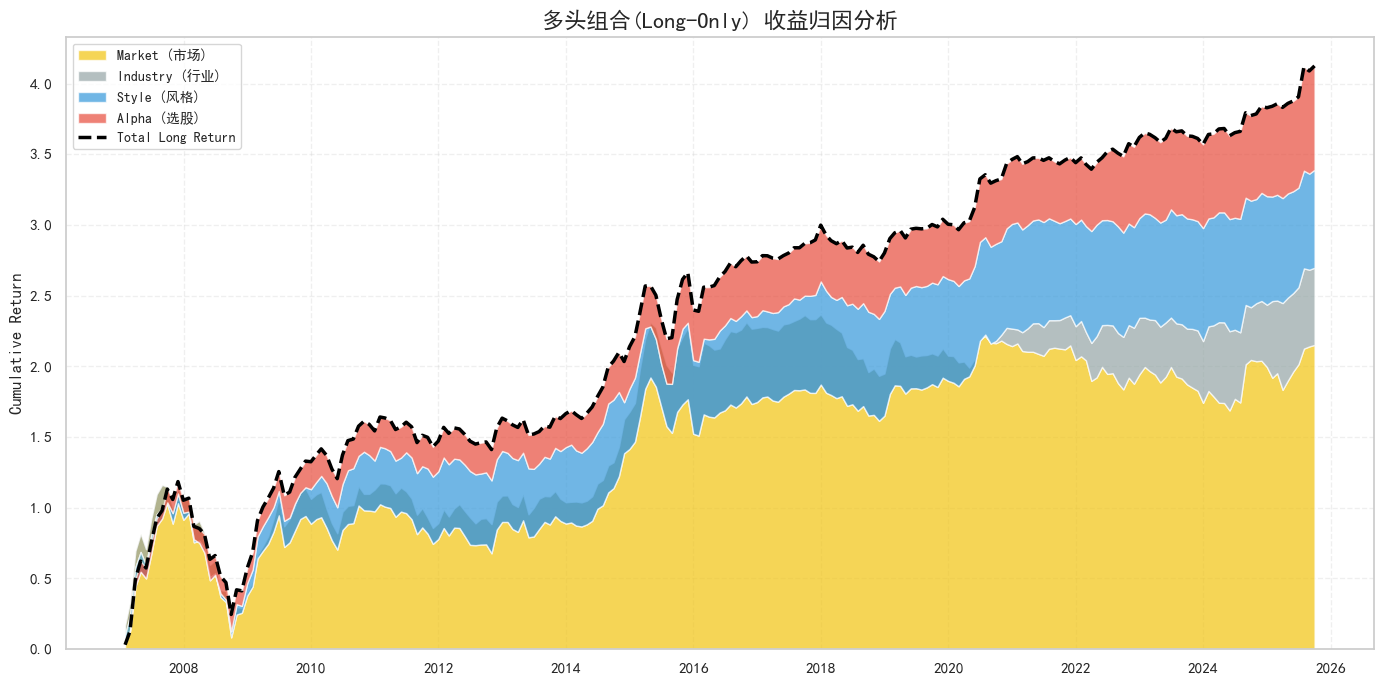

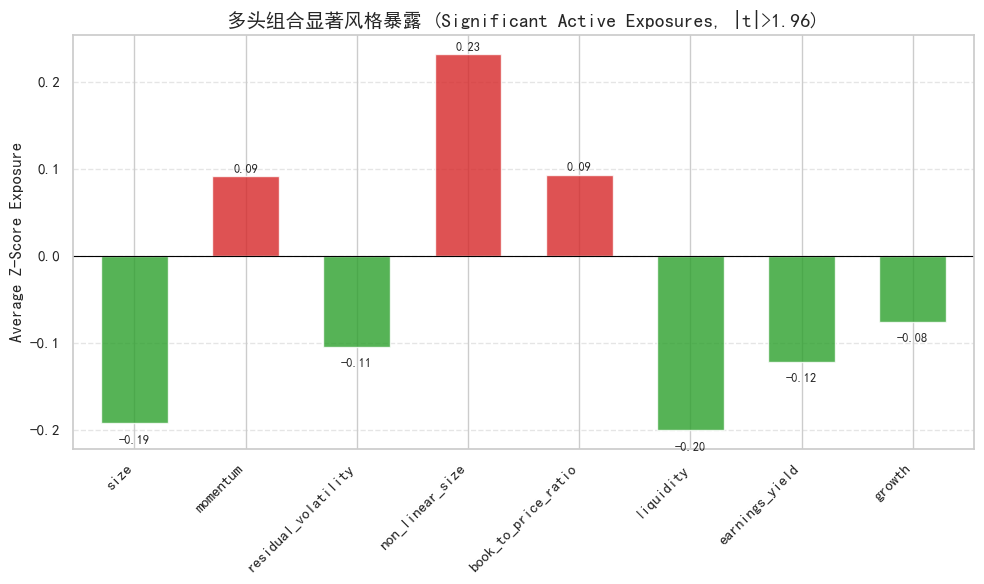


>>> 多头收益归因总结 (年化, %):
Market      11.47
Industry     2.91
Style        3.70
Alpha        3.92
dtype: float64


In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

print(f"{'='*20} 开始 Barra 业绩归因 (Performance Attribution) {'='*20}")

# 1. 读取基础数据
all_predictions = pd.read_parquet('predictions_with_index.parquet', engine='fastparquet')
all_predictions['date'] = pd.to_datetime(all_predictions['date']) + pd.offsets.MonthEnd(0)

# performance_df 用于获取实际策略总收益，用于后续归因分解
performance_df = pd.read_parquet('performance_RF_with_index.parquet', engine='fastparquet')
if 'date' in performance_df.columns:
    performance_df = performance_df.set_index('date')
performance_df.index = pd.to_datetime(performance_df.index)
# 强制将 performance_df 的索引对齐到月末
performance_df.index = performance_df.index + pd.offsets.MonthEnd(0)

# 2. 重新计算分组 (Group)
# 这一步是为了给 all_predictions 加上 group 列，用于计算策略暴露
def assign_group(x):
    if len(x) < 5:
        return np.nan
    try:
        return pd.qcut(x.rank(method='first'), q=5, labels=False)
    except Exception as e:
        # print(f"Groupby Error: {e}")
        return np.nan

print("正在计算分组信息...")
all_predictions['group'] = all_predictions.groupby('date')['pred_ret'].transform(assign_group)

# 3. 读取并准备 Barra 和 行业数据
df_barra = pd.read_csv('全A股月度cne5数据_2007-2025.csv')
df_barra['date'] = pd.to_datetime(df_barra['date']) + pd.offsets.MonthEnd(0)

style_factors = [
    'size', 'beta', 'momentum', 'residual_volatility', 'non_linear_size',
    'book_to_price_ratio', 'liquidity', 'earnings_yield', 'growth', 'leverage'
]
valid_style_factors = [c for c in style_factors if c in df_barra.columns]
df_barra_clean = df_barra[['date', 'stkcd'] + valid_style_factors]

# 合并 Barra 因子到 all_predictions
attribution_data = pd.merge(
    all_predictions[['date', 'stkcd', 'next_ret', 'group', 'raw_size']],
    df_barra_clean, 
    on=['date', 'stkcd'],
    how='inner'
)

# 读取并合并行业数据
df_shenwan_industry = pd.read_excel('industry.xlsx', engine='openpyxl')
df_shenwan_industry = df_shenwan_industry.rename(columns={'ts_code': 'stkcd'})
df_shenwan_industry_clean = df_shenwan_industry[['stkcd', 'industry1']] # 使用 industry1

attribution_data = pd.merge(attribution_data, df_shenwan_industry_clean, on='stkcd', how='left')
attribution_data['industry1'] = attribution_data['industry1'].fillna('Unknown')

# 生成行业哑变量
attribution_data = pd.get_dummies(attribution_data, columns=['industry1'], prefix='IND', drop_first=True, dtype=int)

# 定义所有用于回归的因子 (Barra 风格 + 行业)
industry_cols = [c for c in attribution_data.columns if c.startswith('IND_')]
all_factors = valid_style_factors + industry_cols

# ==========================================
# 4. 计算 Barra 因子收益率 (Factor Returns)
# ==========================================
# 对每一期做横截面回归：R_i = beta * F + u
# 得到当期的因子收益率 F_t

def estimate_factor_returns(group):
    # 过滤掉缺失值
    group = group.dropna(subset=['next_ret'] + all_factors)
    
    if len(group) < len(all_factors) + 10:
        return None
    
    Y = group['next_ret']
    X = group[all_factors]
    
    # WLS 加权回归 (用根号市值加权)
    weights = np.sqrt(group['raw_size'].fillna(0))
    
    try:
        # 加入截距项 (代表市场因子或基准收益)
        X_with_const = sm.add_constant(X)
        model = sm.WLS(Y, X_with_const, weights=weights).fit()
        return model.params
    except:
        return None

print("正在估算 Barra 因子收益率...")
factor_returns_df = attribution_data.groupby('date').apply(estimate_factor_returns)

# 检查因子收益率是否计算成功
if factor_returns_df.empty:
    raise ValueError("因子收益率计算失败，请检查数据日期对齐或样本量")

# ==========================================
# 5. 计算 多头组合 的因子暴露 (Portfolio Exposures)
# ==========================================
# 目标：只计算 Group 4 (多头组) 的加权平均暴露

def calc_long_portfolio_exposure(group):
    # 筛选多头组 (Group 4)
    long_port = group[group['group'] == 4.0]
    
    if len(long_port) == 0:
        return None
    
    # 确保因子数据无缺失
    long_port = long_port.dropna(subset=all_factors + ['raw_size'])
    if len(long_port) == 0:
        return None

    # 计算权重 (市值加权)
    w_long = long_port['raw_size'] / long_port['raw_size'].sum()
    
    # 计算加权平均暴露
    # X_bar = sum(w_i * X_i)
    # 这里的 factors 包括 Style + Industry + const(1)
    
    # 构造暴露矩阵 (包含 const=1，用于归因 Market 部分)
    factors_to_exp = all_factors
    
    # 计算风格和行业的加权暴露
    exp_long = (long_port[factors_to_exp].T * w_long.values).sum(axis=1)
    
    # Market (const) 暴露对于纯多头组合始终为 1 (因为 sum(w)=1)
    exp_long['const'] = 1.0 
    
    return exp_long

print("正在计算多头组合风险暴露...")
portfolio_exposures_df = attribution_data.groupby('date').apply(calc_long_portfolio_exposure)


# ==========================================
# 6. 归因计算 (Attribution) - 针对多头 VW_Long
# ==========================================
# 确保索引对齐
common_dates = factor_returns_df.index.intersection(portfolio_exposures_df.index)
# 再次与 performance_df 的索引取交集，确保能取到实际收益
common_dates = common_dates.intersection(performance_df.index)

f_ret = factor_returns_df.loc[common_dates]
p_exp = portfolio_exposures_df.loc[common_dates]

# 逐项相乘得到贡献: Contribution = Exposure * Factor_Return
contributions = p_exp * f_ret

# 汇总分类
# 1. Style Contribution
style_contrib = contributions[valid_style_factors].sum(axis=1)
# 2. Industry Contribution
industry_contrib = contributions[industry_cols].sum(axis=1)
# 3. Market Contribution (const)
market_contrib = contributions['const']

# 4. Total Explained = Style + Industry + Market
total_explained = style_contrib + industry_contrib + market_contrib

# 5. Pure Alpha (Specific Return) = Actual Long Return - Total Explained
# 这里使用 VW_Long (多头组实际收益)
actual_ret = performance_df.loc[common_dates, 'VW_Long']
specific_return = actual_ret - total_explained

# 组合成 DataFrame
attribution_summary = pd.DataFrame({
    'Market': market_contrib,
    'Industry': industry_contrib,
    'Style': style_contrib,
    'Alpha': specific_return
})

# ==========================================
# 7. 绘图展示 (修改版)
# ==========================================
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# --- 图1：多头组合累计收益归因堆叠图 ---
cum_attrib = attribution_summary.cumsum()

plt.figure(figsize=(14, 7))

# 使用 stackplot 绘制堆叠面积图
plt.stackplot(cum_attrib.index, 
              cum_attrib['Market'], 
              cum_attrib['Industry'], 
              cum_attrib['Style'], 
              cum_attrib['Alpha'],
              labels=['Market (市场)', 'Industry (行业)', 'Style (风格)', 'Alpha (选股)'],
              alpha=0.7, 
              colors=['#f1c40f', '#95a5a6', '#3498db', '#e74c3c']) # 黄、灰、蓝、红

# 叠加一条总收益曲线 (VW_Long)
cum_actual = actual_ret.cumsum()
plt.plot(cum_actual.index, cum_actual, color='black', linewidth=2.5, linestyle='--', label='Total Long Return')

plt.title('多头组合(Long-Only) 收益归因分析', fontsize=16, fontweight='bold')
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend(loc='upper left', fontsize=10, frameon=True)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- 图2：显著风格因子的平均暴露 (T检验筛选) ---
# 计算平均暴露
avg_exposures = p_exp[valid_style_factors].mean()

# 计算暴露序列的 T 值 (检验是否显著不为0)
t_stats = pd.Series(index=valid_style_factors, dtype=float)
for col in valid_style_factors:
    # 简单 T 检验: mean / (std / sqrt(N))
    # 也可以用 scipy.stats.ttest_1samp
    series = p_exp[col].dropna()
    if len(series) > 1:
        t, _ = stats.ttest_1samp(series, 0)
        t_stats[col] = t
    else:
        t_stats[col] = 0

# 筛选显著的因子 (|t| > 1.96)
# 行业因子通常不展示在风格暴露图中，这里只展示 Style Factors
sig_mask = t_stats.abs() > 1.96
sig_exposures = avg_exposures[sig_mask]

if not sig_exposures.empty:
    plt.figure(figsize=(10, 6))
    
    # 颜色逻辑：正暴露红色，负暴露绿色
    colors = ['#d62728' if x > 0 else '#2ca02c' for x in sig_exposures]
    
    # 绘制柱状图
    ax = sig_exposures.plot(kind='bar', color=colors, alpha=0.8, width=0.6)
    
    plt.axhline(0, color='black', linewidth=0.8)
    plt.title('多头组合显著风格暴露 (Significant Active Exposures, |t|>1.96)', fontsize=14)
    plt.ylabel('Average Z-Score Exposure', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    
    # 添加数值标签
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5 if p.get_height() > 0 else -12), 
                    textcoords = 'offset points',
                    fontsize=9)
    
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("\n[提示] 多头组合在所有风格因子上的平均暴露均不显著 (|t| < 1.96)。")

# 打印数值总结
print("\n>>> 多头收益归因总结 (年化, %):")
ann_factor = 12
summary_stats = attribution_summary.mean() * ann_factor * 100
print(summary_stats.round(2))

# 保存 RF 结果供后续合并绘图使用
attribution_summary_rf = attribution_summary.copy()
p_exp_rf = p_exp.copy()
valid_style_factors_rf = list(valid_style_factors)
actual_ret_rf = actual_ret.copy()

==================== 开始 Barra 业绩归因 (Performance Attribution) ====================
正在计算分组信息...
正在估算 Barra 因子收益率...
正在估算 Barra 因子收益率...


/var/folders/3v/qp1m5cd16l5dgvqp5zlpv9rh0000gn/T/ipykernel_99958/252407769.py:97: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  factor_returns_df = attribution_data.groupby('date').apply(estimate_factor_returns)


正在计算多头组合风险暴露...


/var/folders/3v/qp1m5cd16l5dgvqp5zlpv9rh0000gn/T/ipykernel_99958/252407769.py:139: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_exposures_df = attribution_data.groupby('date').apply(calc_long_portfolio_exposure)


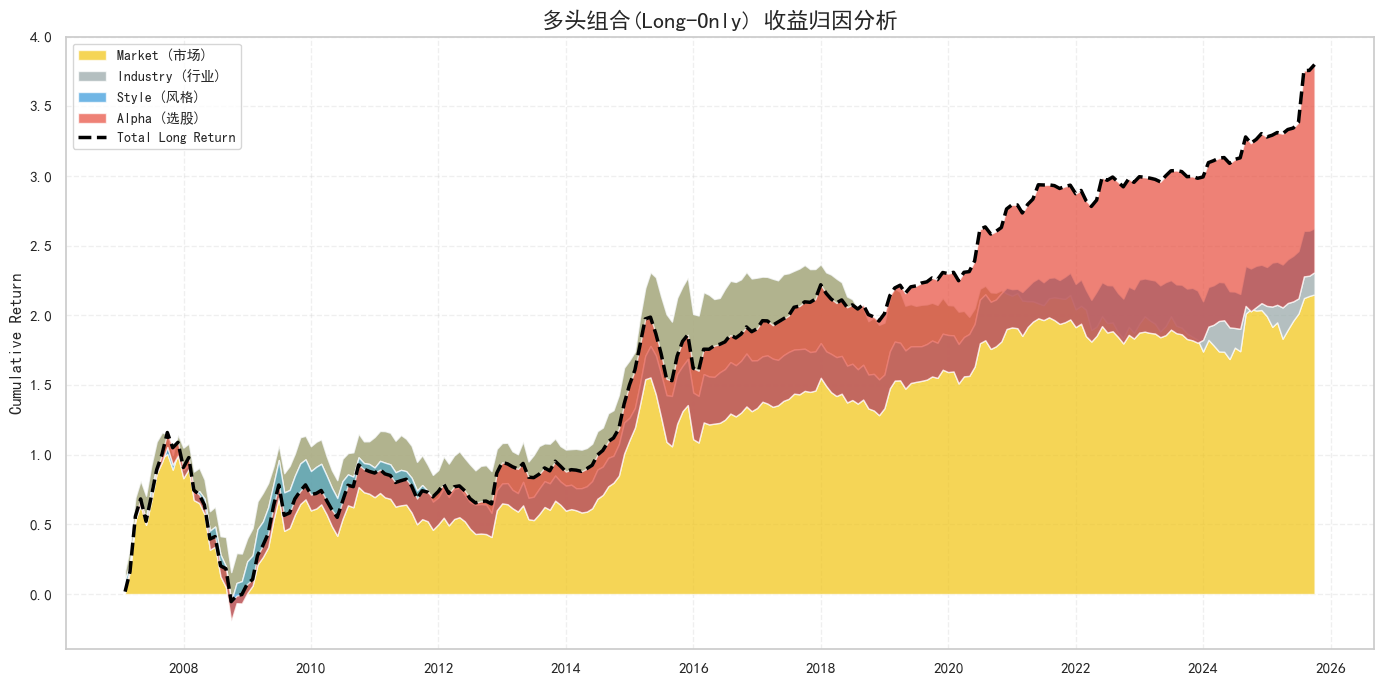

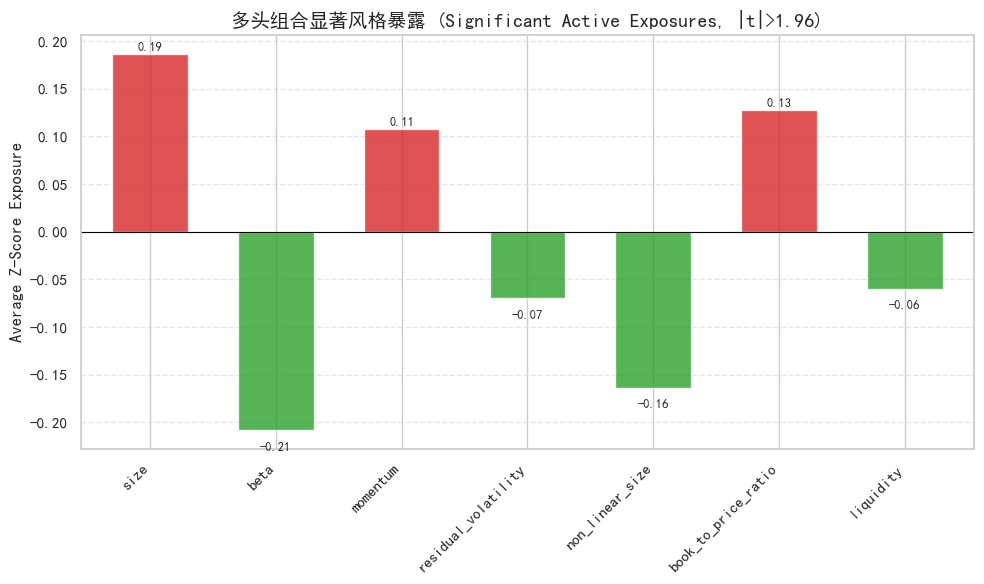


>>> 多头收益归因总结 (年化, %):
Market      11.47
Industry     2.54
Style       -1.69
Alpha        7.95
dtype: float64


In [10]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

print(f"{'='*20} 开始 Barra 业绩归因 (Performance Attribution) {'='*20}")

# 1. 读取基础数据
all_predictions = pd.read_parquet('predictions_XGBoost_with_index.parquet', engine='fastparquet')
all_predictions['date'] = pd.to_datetime(all_predictions['date']) + pd.offsets.MonthEnd(0)

# performance_df 用于获取实际策略总收益，用于后续归因分解
performance_df = pd.read_parquet('performance_with_index.parquet', engine='fastparquet')
if 'date' in performance_df.columns:
    performance_df = performance_df.set_index('date')
performance_df.index = pd.to_datetime(performance_df.index)
# 强制将 performance_df 的索引对齐到月末
performance_df.index = performance_df.index + pd.offsets.MonthEnd(0)

# 2. 重新计算分组 (Group)
# 这一步是为了给 all_predictions 加上 group 列，用于计算策略暴露
def assign_group(x):
    if len(x) < 5:
        return np.nan
    try:
        return pd.qcut(x.rank(method='first'), q=5, labels=False)
    except Exception as e:
        # print(f"Groupby Error: {e}")
        return np.nan

print("正在计算分组信息...")
all_predictions['group'] = all_predictions.groupby('date')['pred_ret'].transform(assign_group)

# 3. 读取并准备 Barra 和 行业数据
df_barra = pd.read_csv('全A股月度cne5数据_2007-2025.csv')
df_barra['date'] = pd.to_datetime(df_barra['date']) + pd.offsets.MonthEnd(0)

style_factors = [
    'size', 'beta', 'momentum', 'residual_volatility', 'non_linear_size',
    'book_to_price_ratio', 'liquidity', 'earnings_yield', 'growth', 'leverage'
 ]
valid_style_factors = [c for c in style_factors if c in df_barra.columns]
df_barra_clean = df_barra[['date', 'stkcd'] + valid_style_factors]

# 合并 Barra 因子到 all_predictions
attribution_data = pd.merge(
    all_predictions[['date', 'stkcd', 'next_ret', 'group', 'raw_size']],
    df_barra_clean, 
    on=['date', 'stkcd'],
    how='inner'
 )

# 读取并合并行业数据
df_shenwan_industry = pd.read_excel('industry.xlsx', engine='openpyxl')
df_shenwan_industry = df_shenwan_industry.rename(columns={'ts_code': 'stkcd'})
df_shenwan_industry_clean = df_shenwan_industry[['stkcd', 'industry1']] # 使用 industry1

attribution_data = pd.merge(attribution_data, df_shenwan_industry_clean, on='stkcd', how='left')
attribution_data['industry1'] = attribution_data['industry1'].fillna('Unknown')

# 生成行业哑变量
attribution_data = pd.get_dummies(attribution_data, columns=['industry1'], prefix='IND', drop_first=True, dtype=int)

# 定义所有用于回归的因子 (Barra 风格 + 行业)
industry_cols = [c for c in attribution_data.columns if c.startswith('IND_')]
all_factors = valid_style_factors + industry_cols

# ==========================================
# 4. 计算 Barra 因子收益率 (Factor Returns)
# ==========================================
# 对每一期做横截面回归：R_i = beta * F + u
# 得到当期的因子收益率 F_t

def estimate_factor_returns(group):
    # 过滤掉缺失值
    group = group.dropna(subset=['next_ret'] + all_factors)
    
    if len(group) < len(all_factors) + 10:
        return None
    
    Y = group['next_ret']
    X = group[all_factors]
    
    # WLS 加权回归 (用根号市值加权)
    weights = np.sqrt(group['raw_size'].fillna(0))
    
    try:
        # 加入截距项 (代表市场因子或基准收益)
        X_with_const = sm.add_constant(X)
        model = sm.WLS(Y, X_with_const, weights=weights).fit()
        return model.params
    except:
        return None

print("正在估算 Barra 因子收益率...")
factor_returns_df = attribution_data.groupby('date').apply(estimate_factor_returns)

# 检查因子收益率是否计算成功
if factor_returns_df.empty:
    raise ValueError("因子收益率计算失败，请检查数据日期对齐或样本量")

# ==========================================
# 5. 计算 多头组合 的因子暴露 (Portfolio Exposures)
# ==========================================
# 目标：只计算 Group 4 (多头组) 的加权平均暴露

def calc_long_portfolio_exposure(group):
    # 筛选多头组 (Group 4)
    long_port = group[group['group'] == 4.0]
    
    if len(long_port) == 0:
        return None
    
    # 确保因子数据无缺失
    long_port = long_port.dropna(subset=all_factors + ['raw_size'])
    if len(long_port) == 0:
        return None

    # 计算权重 (市值加权)
    w_long = long_port['raw_size'] / long_port['raw_size'].sum()
    
    # 计算加权平均暴露
    # X_bar = sum(w_i * X_i)
    # 这里的 factors 包括 Style + Industry + const(1)
    
    # 构造暴露矩阵 (包含 const=1，用于归因 Market 部分)
    factors_to_exp = all_factors
    
    # 计算风格和行业的加权暴露
    exp_long = (long_port[factors_to_exp].T * w_long.values).sum(axis=1)
    
    # Market (const) 暴露对于纯多头组合始终为 1 (因为 sum(w)=1)
    exp_long['const'] = 1.0 
    
    return exp_long

print("正在计算多头组合风险暴露...")
portfolio_exposures_df = attribution_data.groupby('date').apply(calc_long_portfolio_exposure)


# ==========================================
# 6. 归因计算 (Attribution) - 针对多头 VW_Long
# ==========================================
# 确保索引对齐
common_dates = factor_returns_df.index.intersection(portfolio_exposures_df.index)
# 再次与 performance_df 的索引取交集，确保能取到实际收益
common_dates = common_dates.intersection(performance_df.index)

f_ret = factor_returns_df.loc[common_dates]
p_exp = portfolio_exposures_df.loc[common_dates]

# 逐项相乘得到贡献: Contribution = Exposure * Factor_Return
contributions = p_exp * f_ret

# 汇总分类
# 1. Style Contribution
style_contrib = contributions[valid_style_factors].sum(axis=1)
# 2. Industry Contribution
industry_contrib = contributions[industry_cols].sum(axis=1)
# 3. Market Contribution (const)
market_contrib = contributions['const']

# 4. Total Explained = Style + Industry + Market
total_explained = style_contrib + industry_contrib + market_contrib

# 5. Pure Alpha (Specific Return) = Actual Long Return - Total Explained
# 这里使用 VW_Long (多头组实际收益)
actual_ret = performance_df.loc[common_dates, 'VW_Long']
specific_return = actual_ret - total_explained

# 组合成 DataFrame
attribution_summary = pd.DataFrame({
    'Market': market_contrib,
    'Industry': industry_contrib,
    'Style': style_contrib,
    'Alpha': specific_return
})

# ==========================================
# 7. 绘图展示 (修改版)
# ==========================================
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# --- 图1：多头组合累计收益归因堆叠图 ---
cum_attrib = attribution_summary.cumsum()

plt.figure(figsize=(14, 7))

# 使用 stackplot 绘制堆叠面积图
plt.stackplot(cum_attrib.index, 
              cum_attrib['Market'], 
              cum_attrib['Industry'], 
              cum_attrib['Style'], 
              cum_attrib['Alpha'],
              labels=['Market (市场)', 'Industry (行业)', 'Style (风格)', 'Alpha (选股)'],
              alpha=0.7, 
              colors=['#f1c40f', '#95a5a6', '#3498db', '#e74c3c']) # 黄、灰、蓝、红

# 叠加一条总收益曲线 (VW_Long)
cum_actual = actual_ret.cumsum()
plt.plot(cum_actual.index, cum_actual, color='black', linewidth=2.5, linestyle='--', label='Total Long Return')

plt.title('多头组合(Long-Only) 收益归因分析', fontsize=16, fontweight='bold')
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend(loc='upper left', fontsize=10, frameon=True)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- 图2：显著风格因子的平均暴露 (T检验筛选) ---
# 计算平均暴露
avg_exposures = p_exp[valid_style_factors].mean()

# 计算暴露序列的 T 值 (检验是否显著不为0)
t_stats = pd.Series(index=valid_style_factors, dtype=float)
for col in valid_style_factors:
    # 简单 T 检验: mean / (std / sqrt(N))
    # 也可以用 scipy.stats.ttest_1samp
    series = p_exp[col].dropna()
    if len(series) > 1:
        t, _ = stats.ttest_1samp(series, 0)
        t_stats[col] = t
    else:
        t_stats[col] = 0

# 筛选显著的因子 (|t| > 1.96)
# 行业因子通常不展示在风格暴露图中，这里只展示 Style Factors
sig_mask = t_stats.abs() > 1.96
sig_exposures = avg_exposures[sig_mask]

if not sig_exposures.empty:
    plt.figure(figsize=(10, 6))
    
    # 颜色逻辑：正暴露红色，负暴露绿色
    colors = ['#d62728' if x > 0 else '#2ca02c' for x in sig_exposures]
    
    # 绘制柱状图
    ax = sig_exposures.plot(kind='bar', color=colors, alpha=0.8, width=0.6)
    
    plt.axhline(0, color='black', linewidth=0.8)
    plt.title('多头组合显著风格暴露 (Significant Active Exposures, |t|>1.96)', fontsize=14)
    plt.ylabel('Average Z-Score Exposure', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    
    # 添加数值标签
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5 if p.get_height() > 0 else -12), 
                    textcoords = 'offset points',
                    fontsize=9)
    
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("\n[提示] 多头组合在所有风格因子上的平均暴露均不显著 (|t| < 1.96)。")

# 打印数值总结
print("\n>>> 多头收益归因总结 (年化, %):")
ann_factor = 12
summary_stats = attribution_summary.mean() * ann_factor * 100
print(summary_stats.round(2))

# 保存 XGB 结果供后续合并绘图使用
attribution_summary_xgb = attribution_summary.copy()
p_exp_xgb = p_exp.copy()
valid_style_factors_xgb = list(valid_style_factors)
actual_ret_xgb = actual_ret.copy()

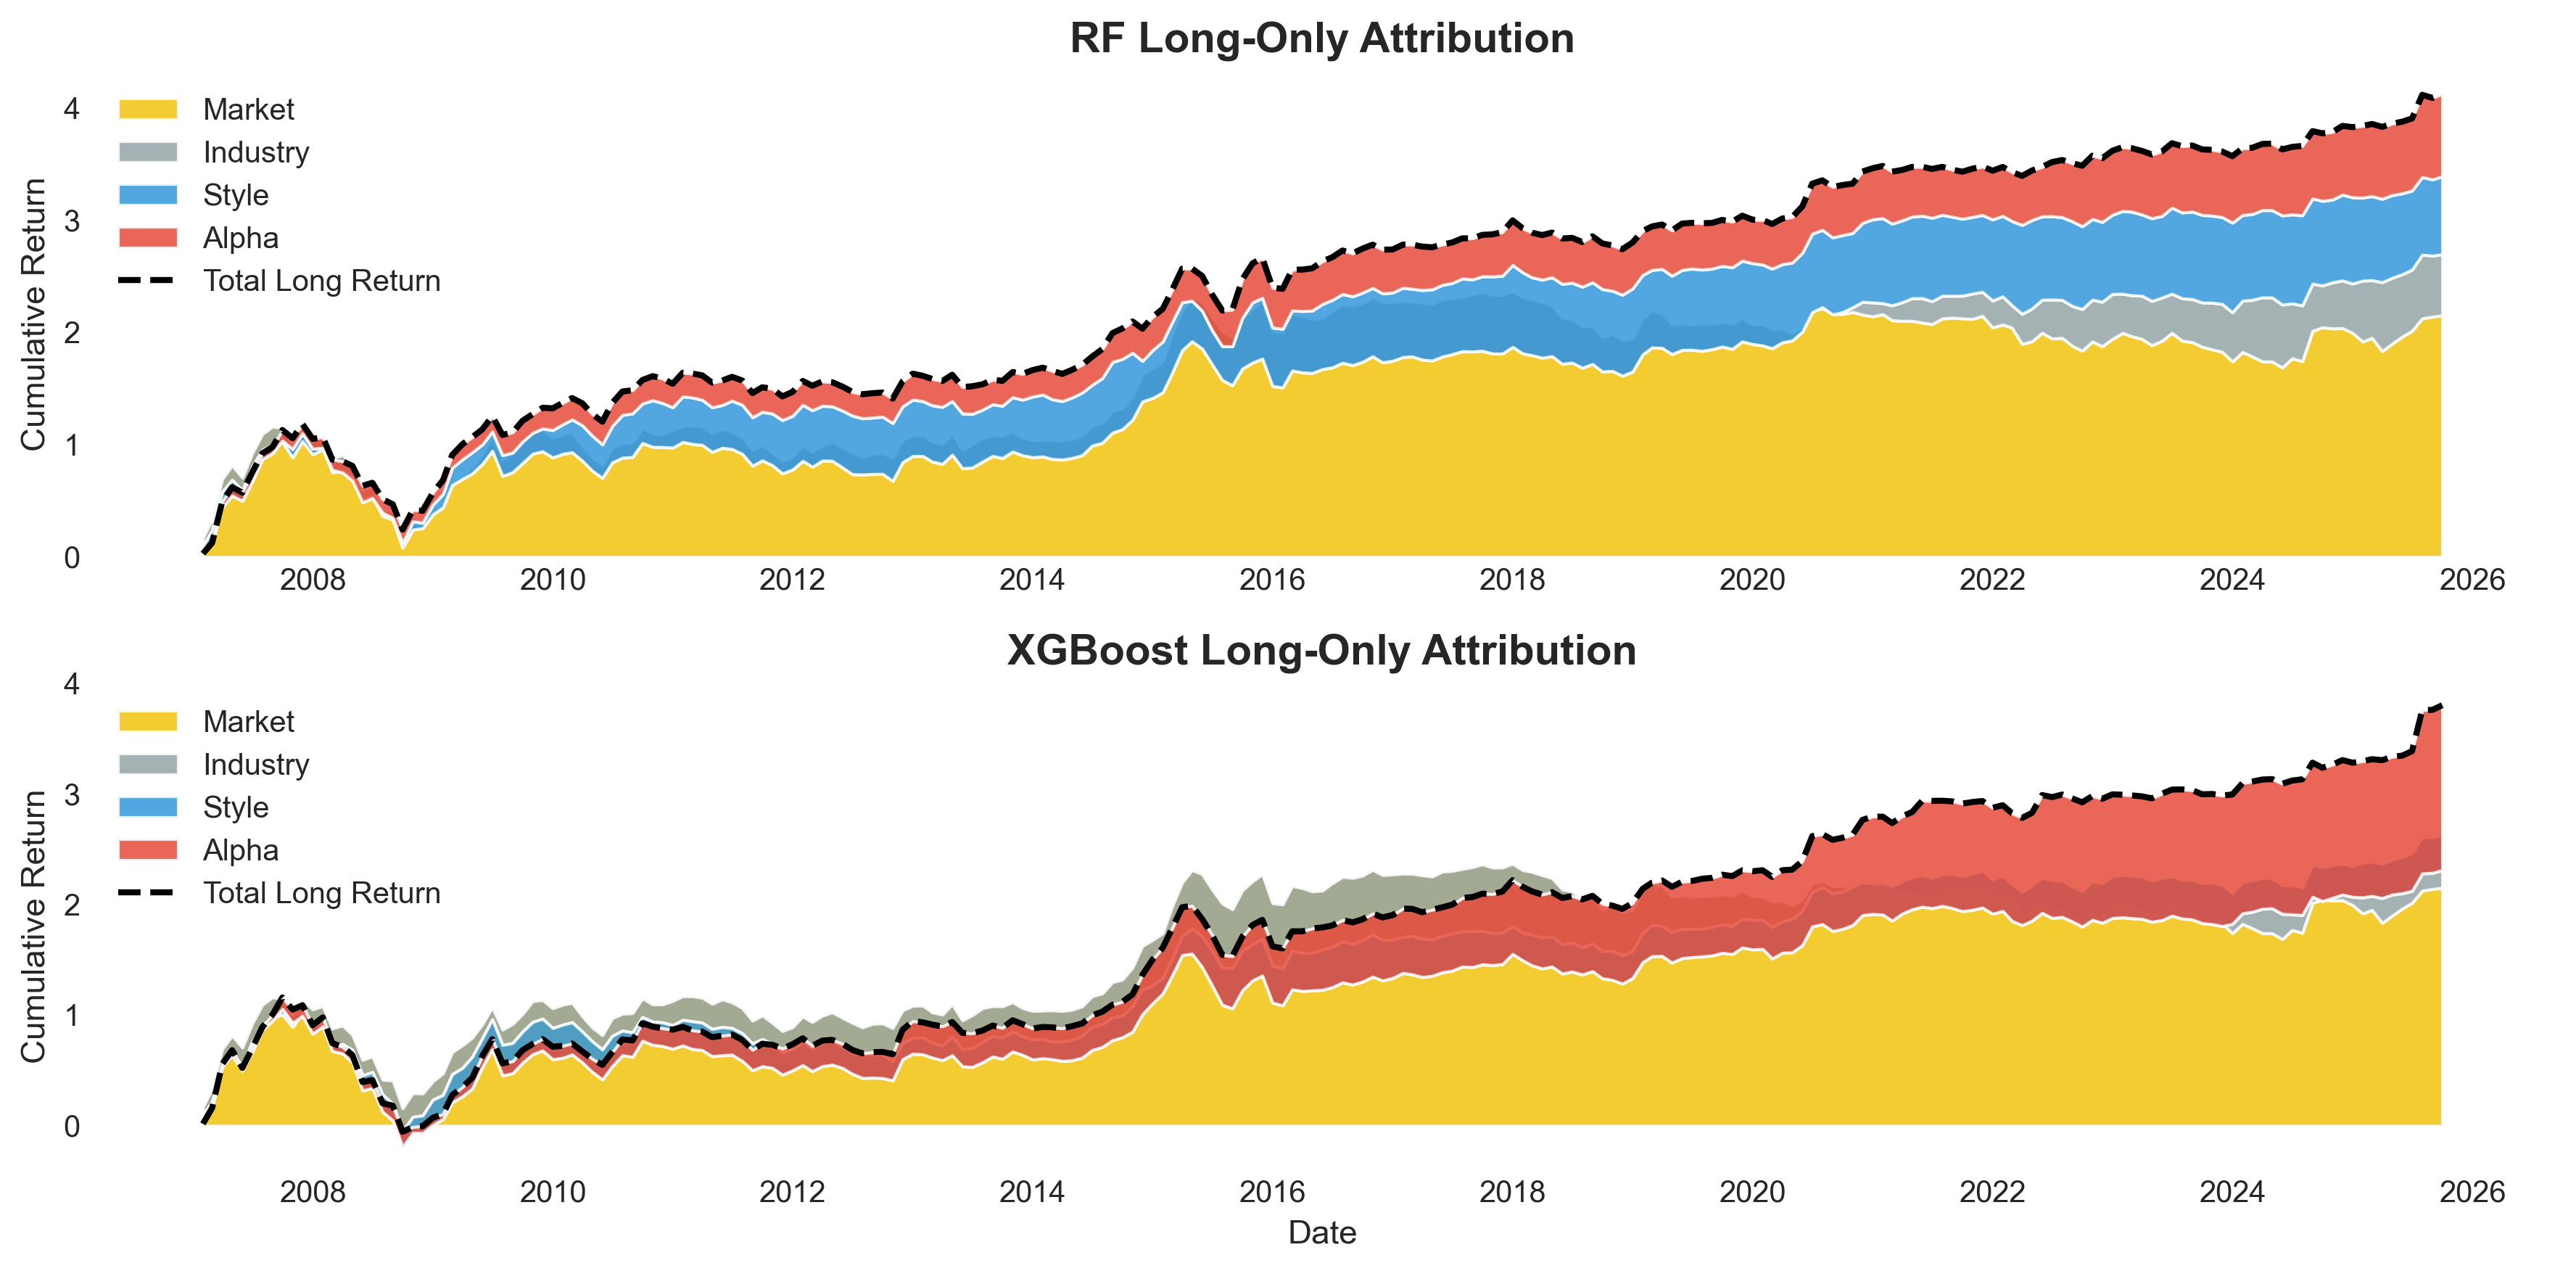

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Combined attribution plots for RF and XGBoost (two rows, one column)
required_vars = ['attribution_summary_rf', 'attribution_summary_xgb', 'actual_ret_rf', 'actual_ret_xgb']
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise RuntimeError(f"Please run the RF and XGBoost attribution cells first to produce: {', '.join(missing)}")

plt.rcParams['font.family'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['savefig.transparent'] = True

fig, axes = plt.subplots(2, 1, figsize=(12, 6), dpi=300)
fig.patch.set_alpha(0)

def plot_attribution(ax, attr_df, actual_series, title):
    cum_attr = attr_df.cumsum()
    ax.stackplot(cum_attr.index,
                 cum_attr['Market'], cum_attr['Industry'], cum_attr['Style'], cum_attr['Alpha'],
                 labels=['Market', 'Industry', 'Style', 'Alpha'],
                 alpha=0.85,
                 colors=['#f1c40f', '#95a5a6', '#3498db', '#e74c3c'])
    ax.plot(actual_series.cumsum().index, actual_series.cumsum(), color='black', linewidth=2.0, linestyle='--', label='Total Long Return')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel('Cumulative Return', fontsize=11)
    ax.legend(loc='upper left', fontsize=10, frameon=False)
    ax.set_facecolor('none')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(False)
    ax.tick_params(axis='both', which='both', length=0, labelsize=10)

plot_attribution(axes[0], attribution_summary_rf, actual_ret_rf, 'RF Long-Only Attribution')
plot_attribution(axes[1], attribution_summary_xgb, actual_ret_xgb, 'XGBoost Long-Only Attribution')

axes[1].set_xlabel('Date', fontsize=11)
plt.tight_layout()
fig.savefig('combined_attribution.pdf', format='pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

/var/folders/3v/qp1m5cd16l5dgvqp5zlpv9rh0000gn/T/ipykernel_99958/914676596.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sig_exposures.index, rotation=45, ha='right', fontsize=10)
/var/folders/3v/qp1m5cd16l5dgvqp5zlpv9rh0000gn/T/ipykernel_99958/914676596.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sig_exposures.index, rotation=45, ha='right', fontsize=10)


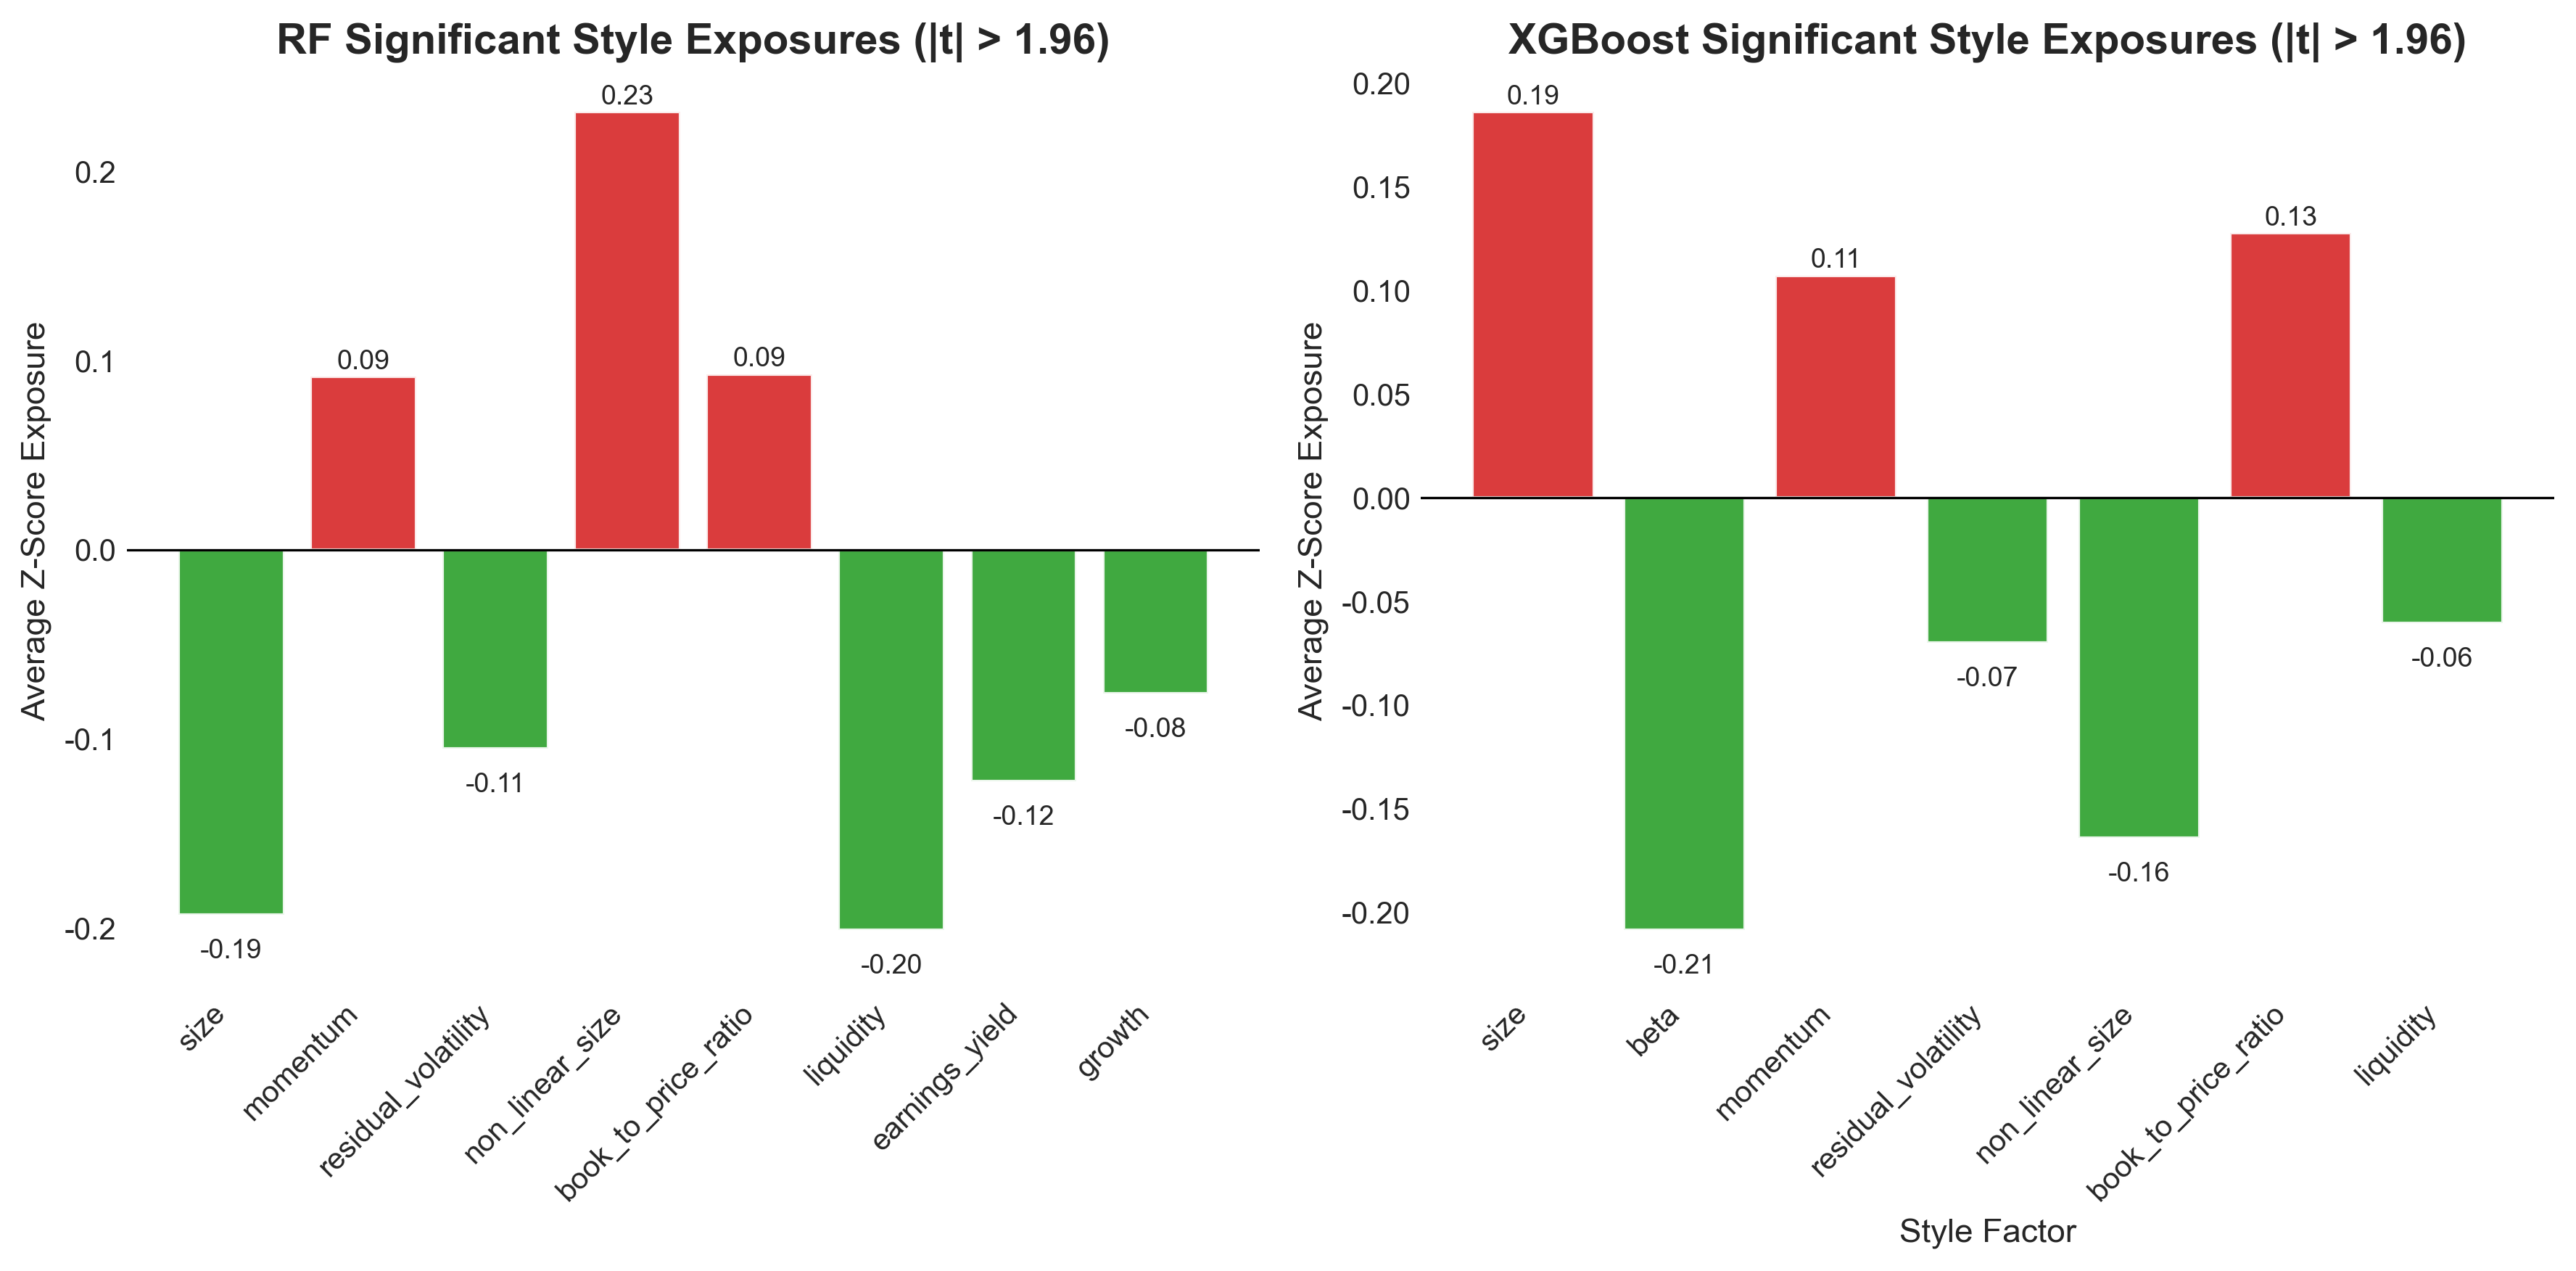

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

# Combined significant style exposures for RF and XGBoost (two rows, one column), bar charts for significant factors
required_vars = ['p_exp_rf', 'p_exp_xgb', 'valid_style_factors_rf', 'valid_style_factors_xgb']
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise RuntimeError(f"Please run the RF and XGBoost attribution cells first to produce: {', '.join(missing)}")

plt.rcParams['font.family'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['savefig.transparent'] = True

fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=300)
fig.patch.set_alpha(0)

def compute_sig_exposures(p_exp, factors):
    avg_exposures = p_exp[factors].mean()
    t_stats = pd.Series(index=factors, dtype=float)
    for col in factors:
        series = p_exp[col].dropna()
        if len(series) > 1:
            t, _ = stats.ttest_1samp(series, 0)
            t_stats[col] = t
        else:
            t_stats[col] = 0
    sig_mask = t_stats.abs() > 1.96
    return avg_exposures[sig_mask]

def plot_sig_bars(ax, p_exp, factors, title):
    sig_exposures = compute_sig_exposures(p_exp, factors)
    if sig_exposures.empty:
        ax.text(0.5, 0.5, 'No significant style factors (|t| ≤ 1.96)', ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')
        return
    colors = ['#d62728' if x > 0 else '#2ca02c' for x in sig_exposures]
    bars = ax.bar(sig_exposures.index, sig_exposures.values, color=colors, alpha=0.9)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel('Average Z-Score Exposure', fontsize=11)
    ax.set_xticklabels(sig_exposures.index, rotation=45, ha='right', fontsize=10)
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', (bar.get_x() + bar.get_width() / 2.0, height), ha='center', va='center', xytext=(0, 5 if height > 0 else -12), textcoords='offset points', fontsize=9)
    ax.set_facecolor('none')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(False)
    ax.tick_params(axis='y', which='both', length=0, labelsize=10)

plot_sig_bars(axes[0], p_exp_rf, valid_style_factors_rf, 'RF Significant Style Exposures (|t| > 1.96)')
plot_sig_bars(axes[1], p_exp_xgb, valid_style_factors_xgb, 'XGBoost Significant Style Exposures (|t| > 1.96)')
axes[1].set_xlabel('Style Factor', fontsize=11)

plt.tight_layout()
fig.savefig('combined_style_exposures.pdf', format='pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()